Nolan Roth <br>
PHYS 434 AC

# Lab #7

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import signal
from scipy.stats import norm
from astropy.table import QTable, Table, Column
from astropy import units as u
import numpy as np
import pickle

plt.rcParams["figure.figsize"] = (15, 10)

In [3]:
infile = open ('higgs_250_500.pkl','rb')
higgs_data = pickle.load(infile)
infile = open ('qcd_250_500.pkl', 'rb')
qcd_data = pickle.load(infile)

In [54]:
higgs_data.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

## Problem 1

Making a stacked histogram for Higgs mass data versus QCD mass data: 

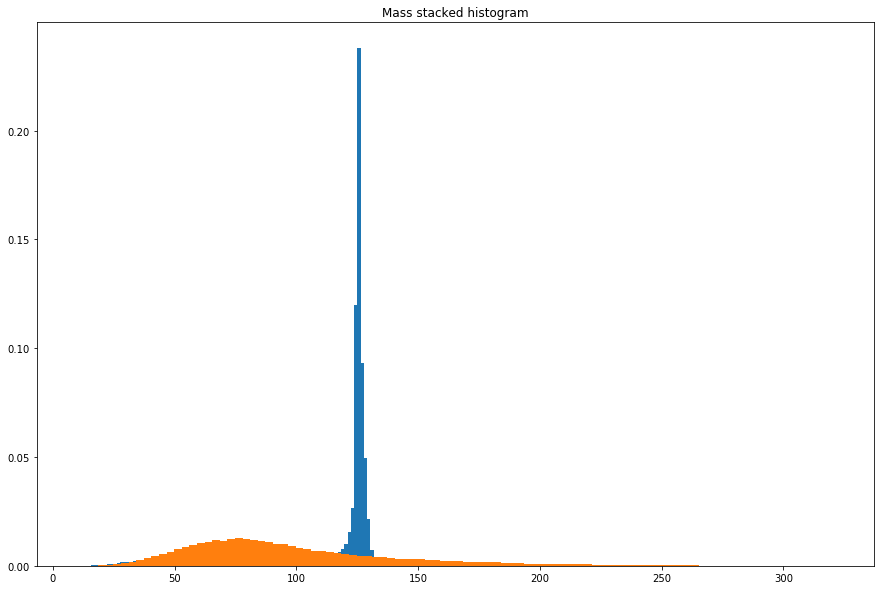

In [73]:
plt.hist(higgs_data['mass'], 100, density=True)
plt.hist(qcd_data['mass'], 100, density=True)
plt.title('Mass stacked histogram')
plt.show()

In [9]:
higgs_temp = higgs_data['mass'].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['mass'].values
qcd_events = qcd_temp[0:len(qcd_temp)]

Calculating the significance without any mass cuts:

In [25]:
total_events = len(higgs_events) + len(qcd_events)
normalized_higgs = 100
normalized_qcd = 20000
print('Significance without any cuts: ' + str(stats.norm.ppf(stats.poisson.cdf(normalized_higgs + normalized_qcd, normalized_qcd))))
print('N(Higgs) / sqrt(N(QCD)) = ' + str(normalized_higgs/(normalized_qcd)**(1/2)))

Significance without any cuts: 0.7112259282313185
N(Higgs) / sqrt(N(QCD)) = 0.7071067811865475


The significance value is very close to the value of N(Higgs) / sqrt(N(QCD)).

## Problem 2

In [45]:
def makeCut(lower, upper):
    cut_higgs_indices = []
    cut_qcd_indices = []
    higgs_count = 0
    qcd_count = 0
    for i in range(0, len(higgs_events)):
        if higgs_events[i] >= lower and higgs_events[i] <= upper:
            cut_higgs_indices.append(i)
    for j in range(0, len(qcd_events)):
        if qcd_events[j] >= lower and qcd_events[j] <= upper:
            cut_qcd_indices.append(j)
    total_events = len(cut_higgs_indices) + len(cut_qcd_indices)
    normalized_higgs = 2 * 100 * (len(cut_higgs_indices) / total_events)
    normalized_qcd = 2 * 20000 * (len(cut_qcd_indices) / total_events)
    # multiplying the above values by 2 to account for the fact that when the counts are equal they
    # should be normalized to 100 and 20,000, not 50 and 10,000
    return [normalized_higgs, normalized_qcd, cut_higgs_indices, cut_qcd_indices]

Going forwards from 0 to 140 to find the optimal minimum for a mass cut:

In [46]:
max_sig = 0
max_lower = 0
for i in range(0, 140):
    higgs_count = makeCut(i, 140)[0]
    qcd_count = makeCut(i, 140)[1]
    sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
    if sig > max_sig:
        max_sig = sig
        max_lower = i
print(max_sig)
print(max_lower)

3.0760368366047333
124


Going backwards from 140 to 124 to find the optimal maximum for a mass cut:

In [47]:
max_sig = 0
max_upper = 140
for i in range(0, 140 - max_lower):
    higgs_count = makeCut(max_lower, 140 - i)[0]
    qcd_count = makeCut(max_lower, 140 - i)[1]
    sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
    if sig > max_sig:
        max_sig = sig
        max_upper = 140 - i
print(max_sig)
print(max_upper)

6.023057920453272
126


So the optimal mass cut to maximize discovery significance is from 124 to 126.

## Problem 3

Stacked histograms for the rest of the variables:

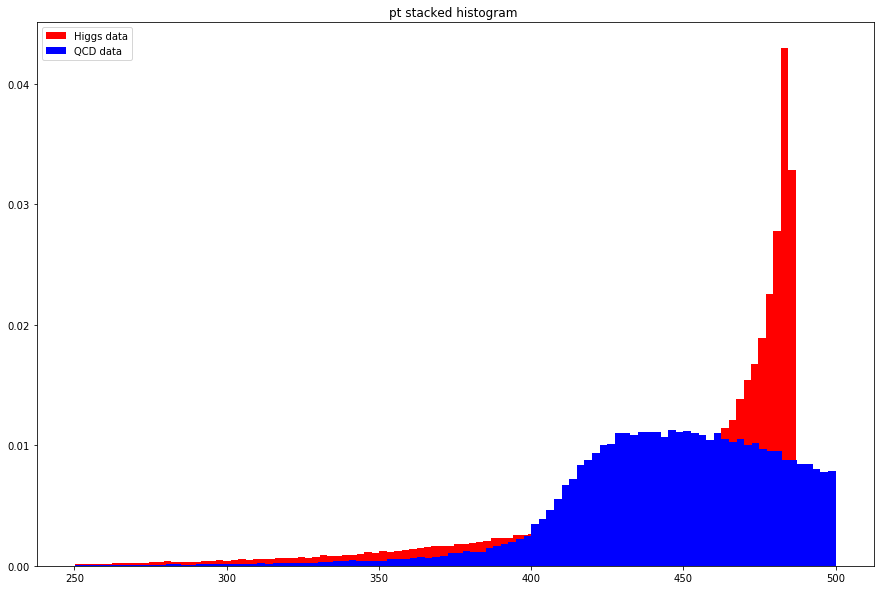

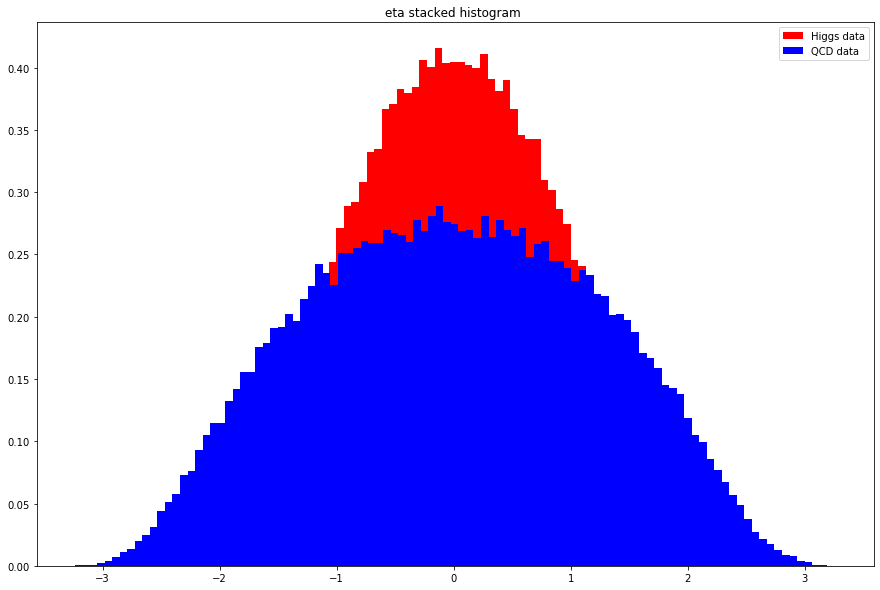

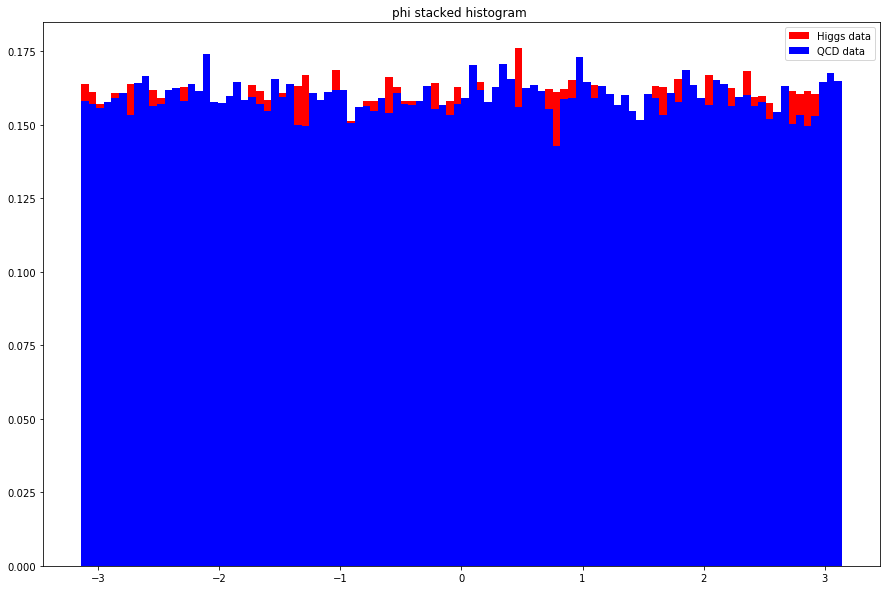

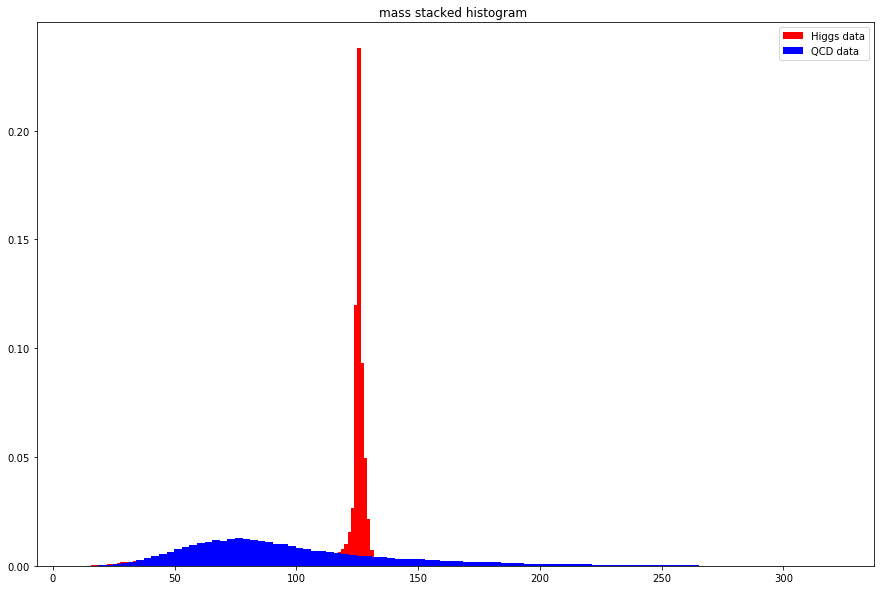

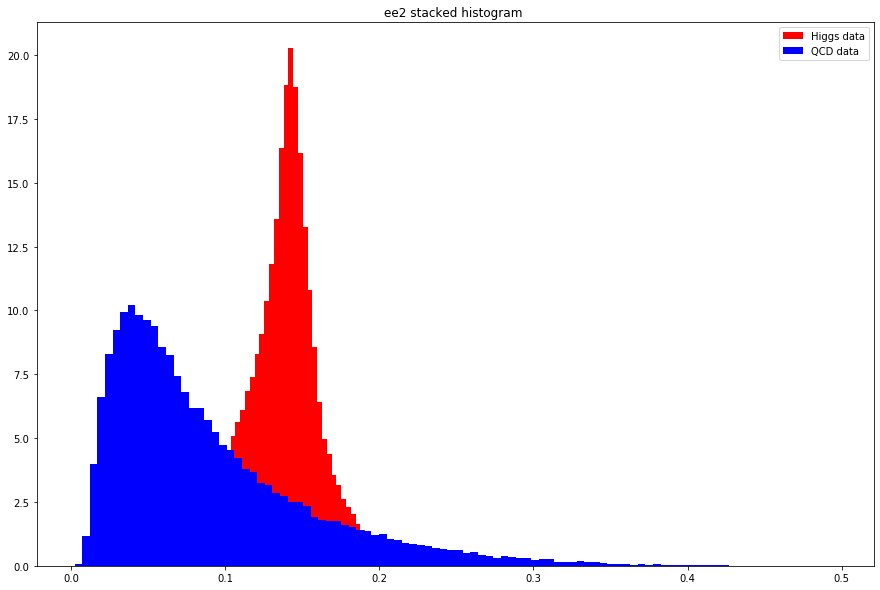

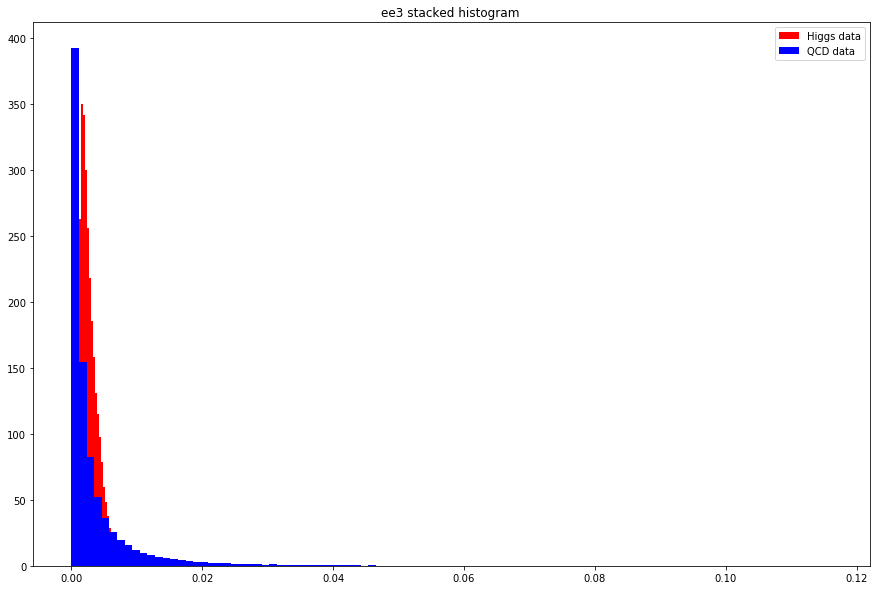

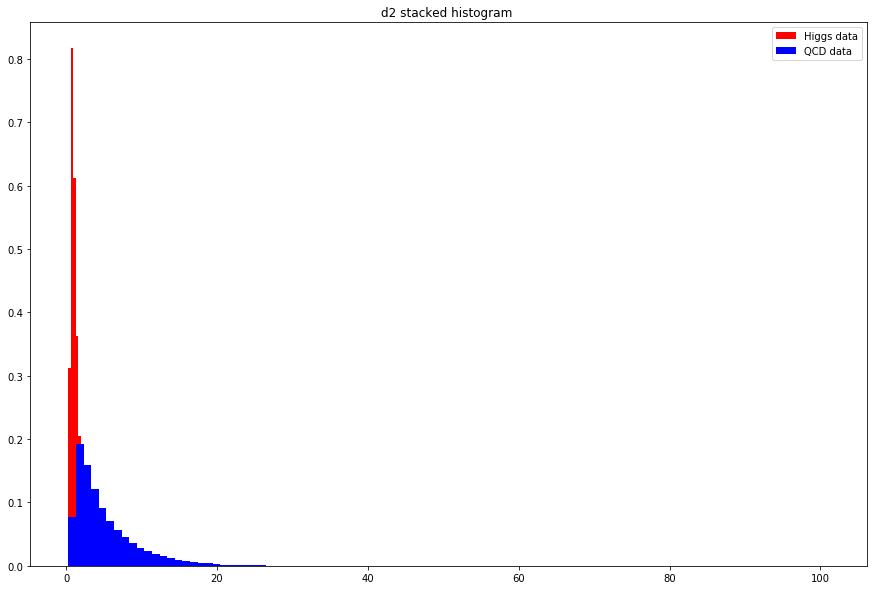

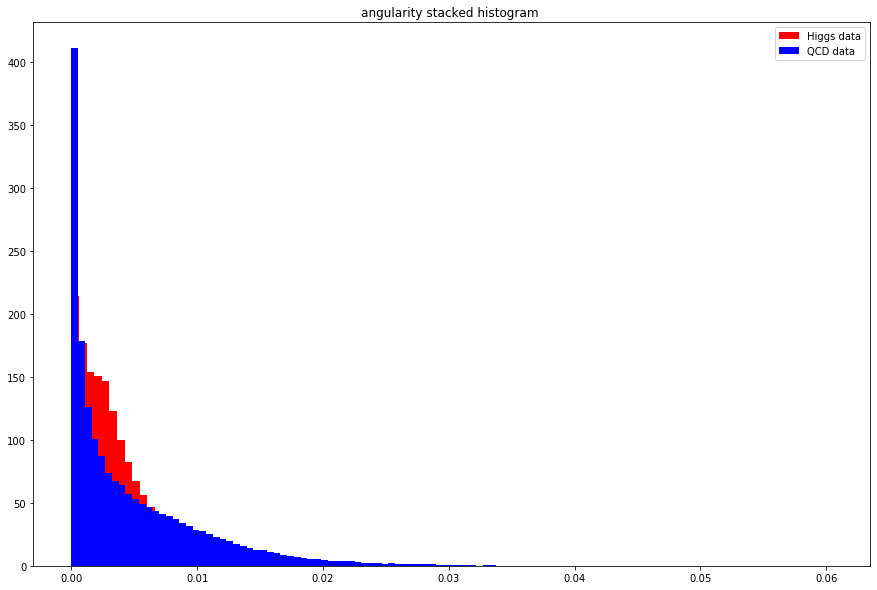

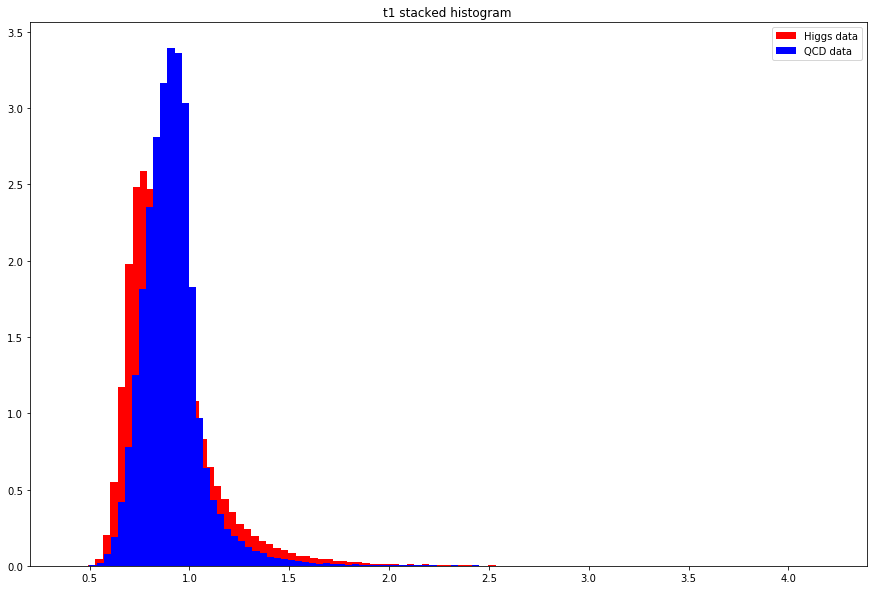

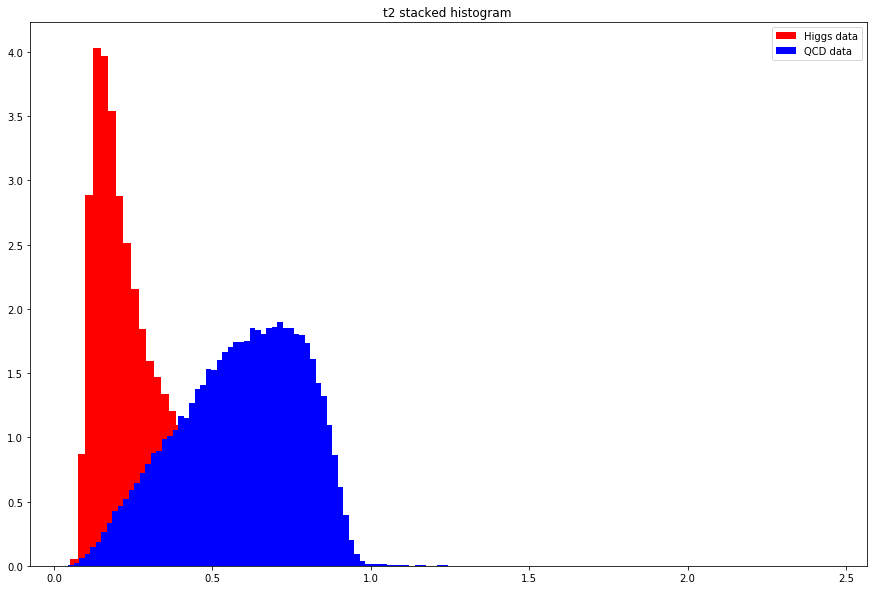

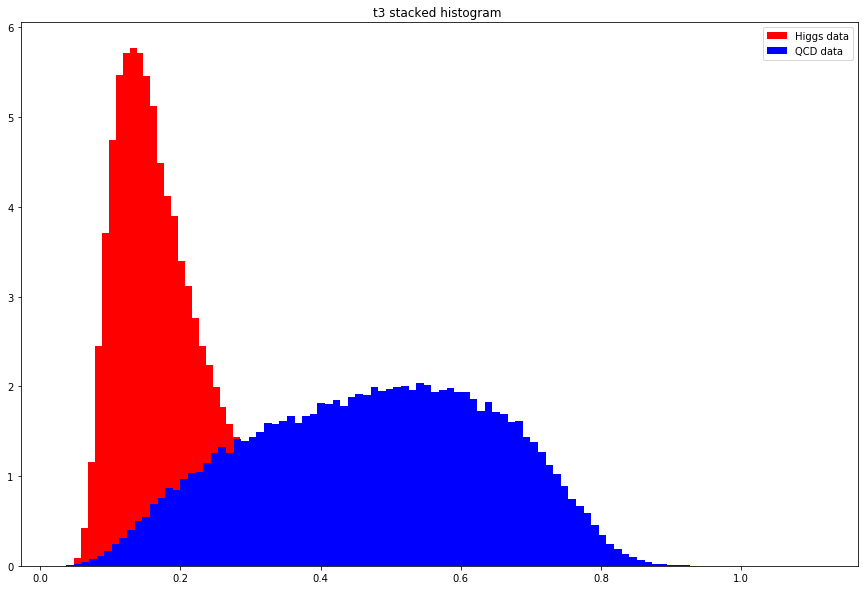

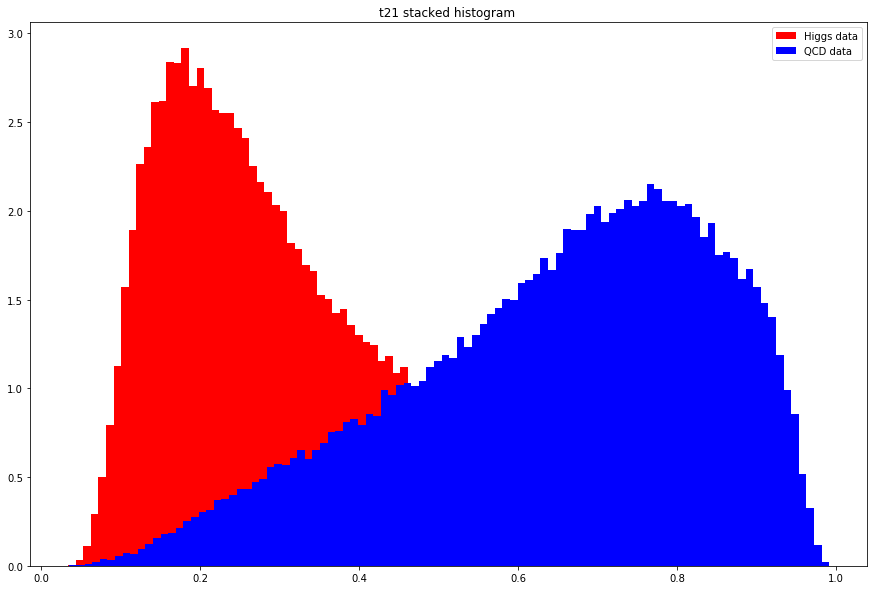

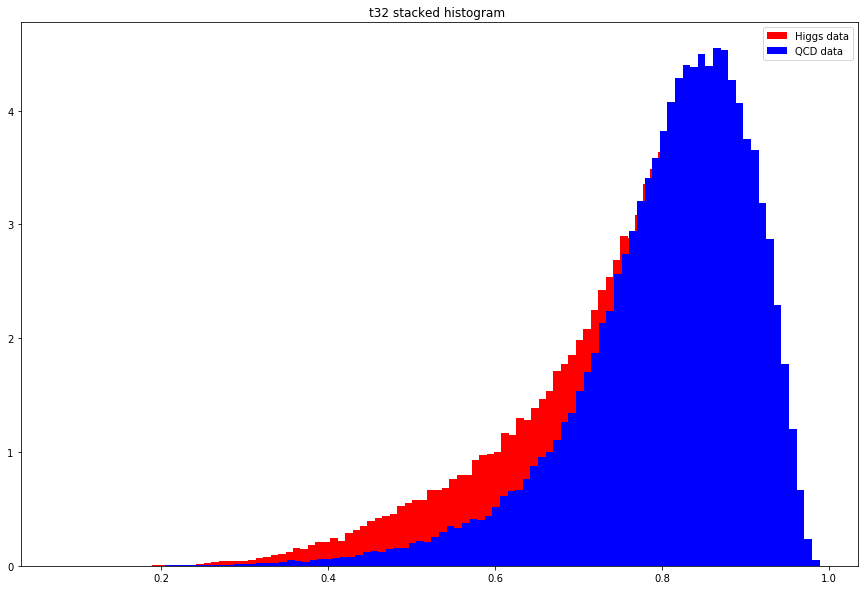

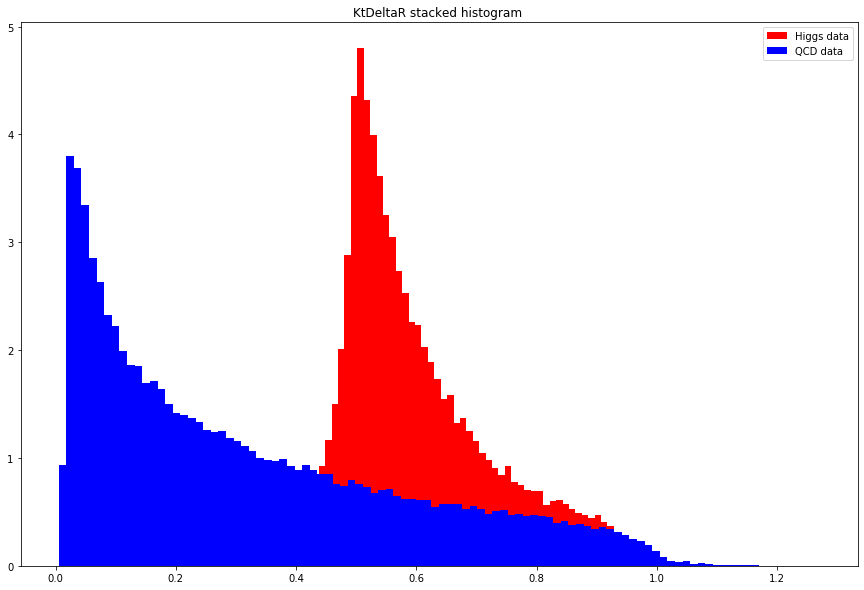

In [79]:
for key in higgs_data.keys():
    plt.hist(higgs_data[key], 100, density=True, color='r', label='Higgs data')
    plt.hist(qcd_data[key], 100, density=True, color='b', label='QCD data')
    plt.title(str(key) + ' stacked histogram ')
    plt.legend()
    plt.show()

In [60]:
cut_higgs_indices = []
cut_qcd_indices = []
for i in range(0, len(higgs_data)):
    if higgs_data['mass'][i] >= 124 and higgs_data['mass'][i] <= 126:
        cut_higgs_indices.append(i)
for j in range(0, len(qcd_data)):
    if qcd_data['mass'][j] >= 124 and qcd_data['mass'][j] <= 126:
        cut_qcd_indices.append(j)
print(len(cut_higgs_indices))
print(len(cut_qcd_indices))

38963
989


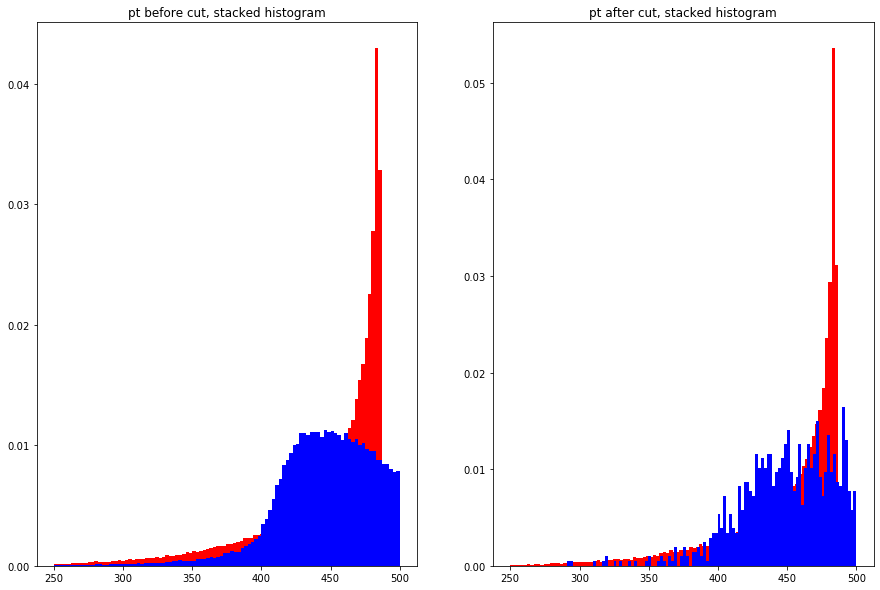

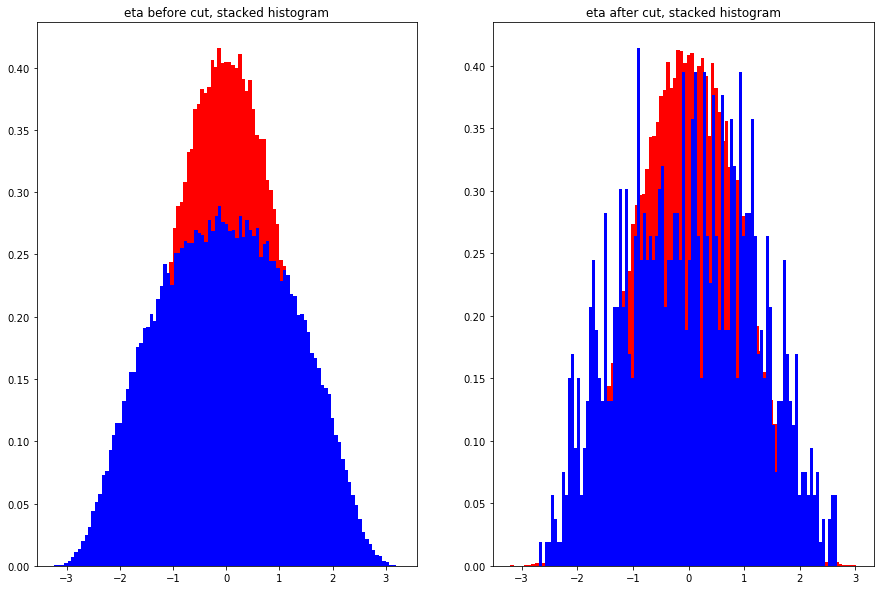

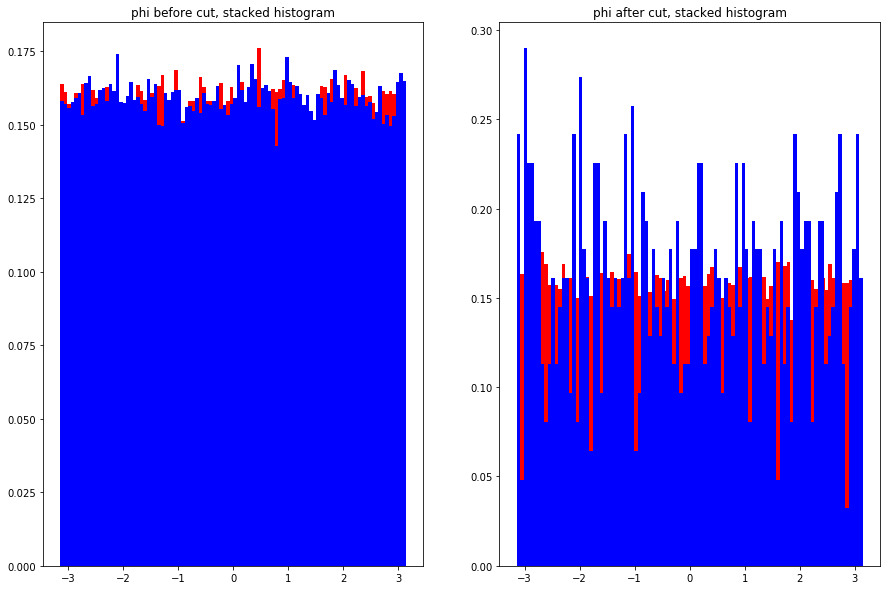

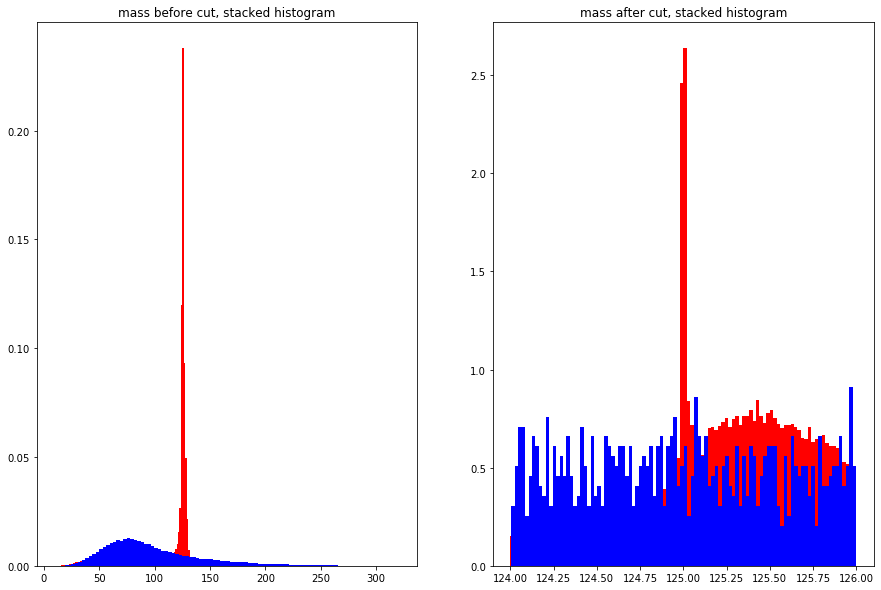

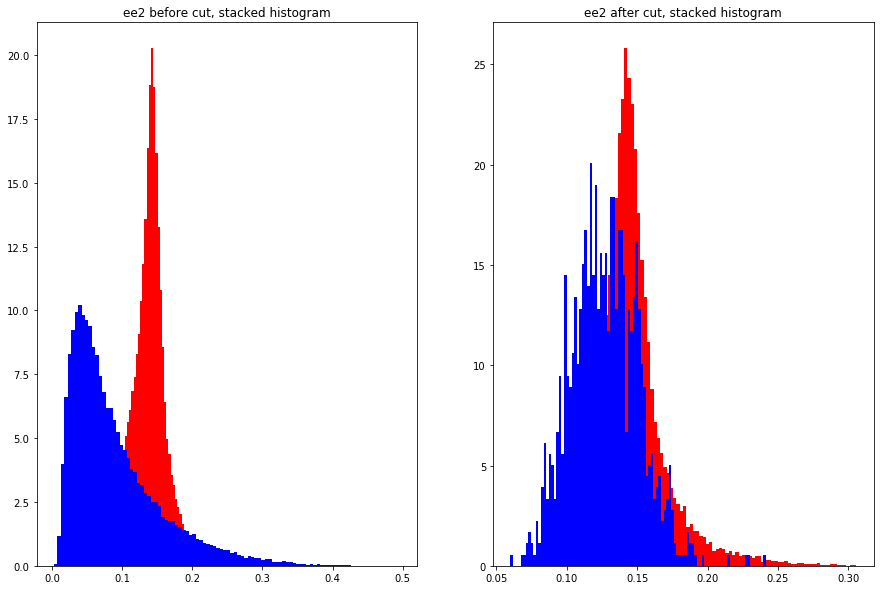

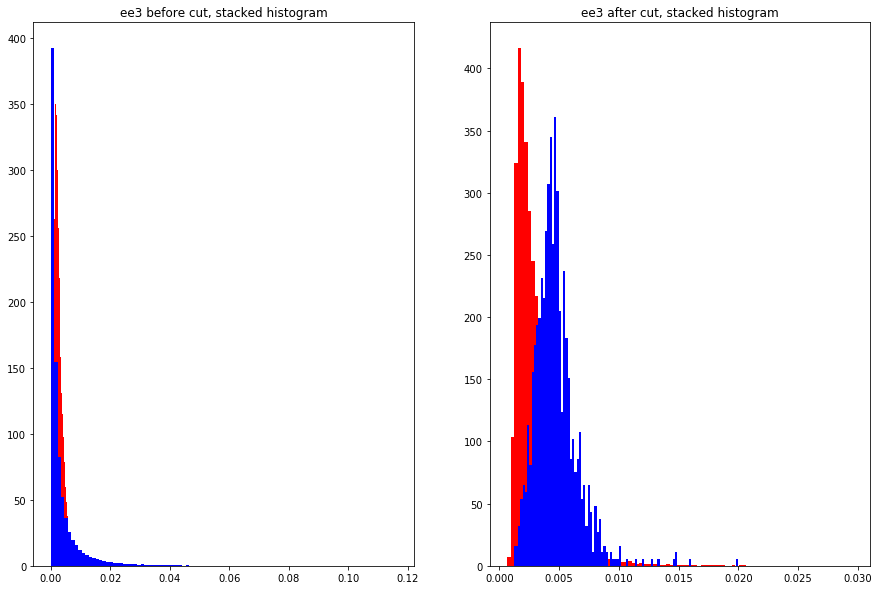

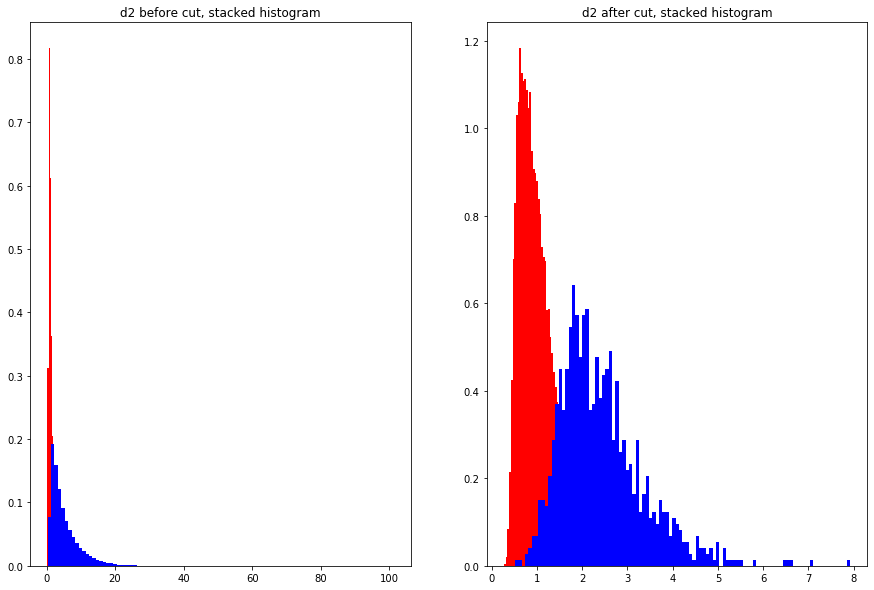

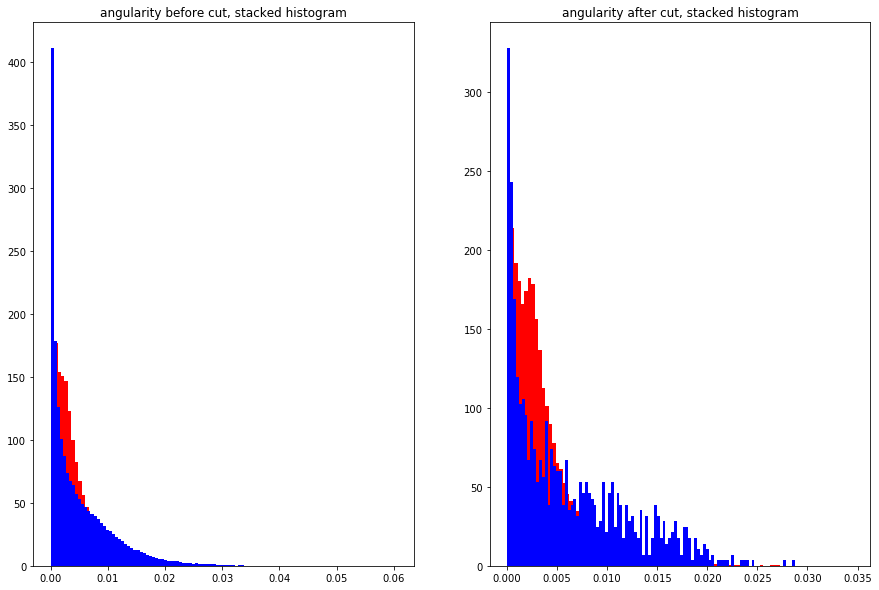

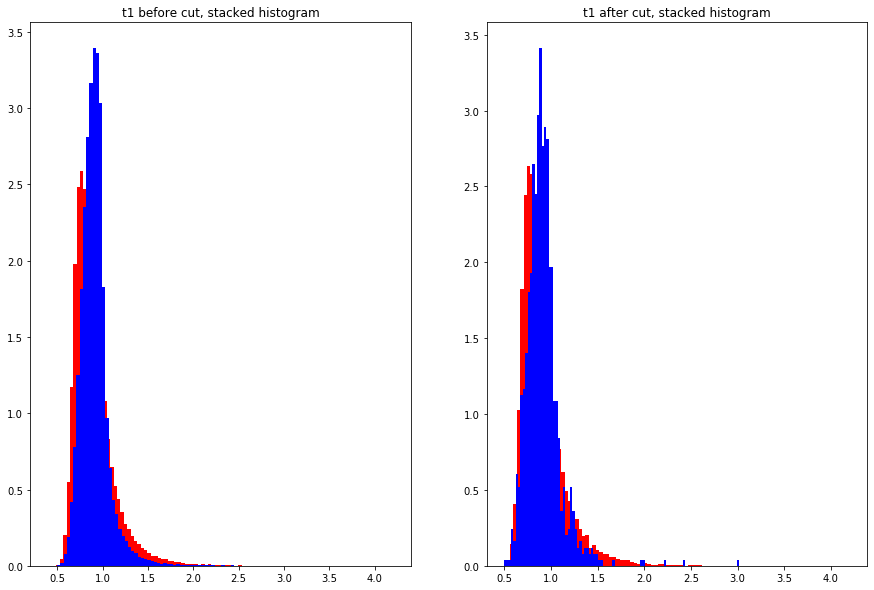

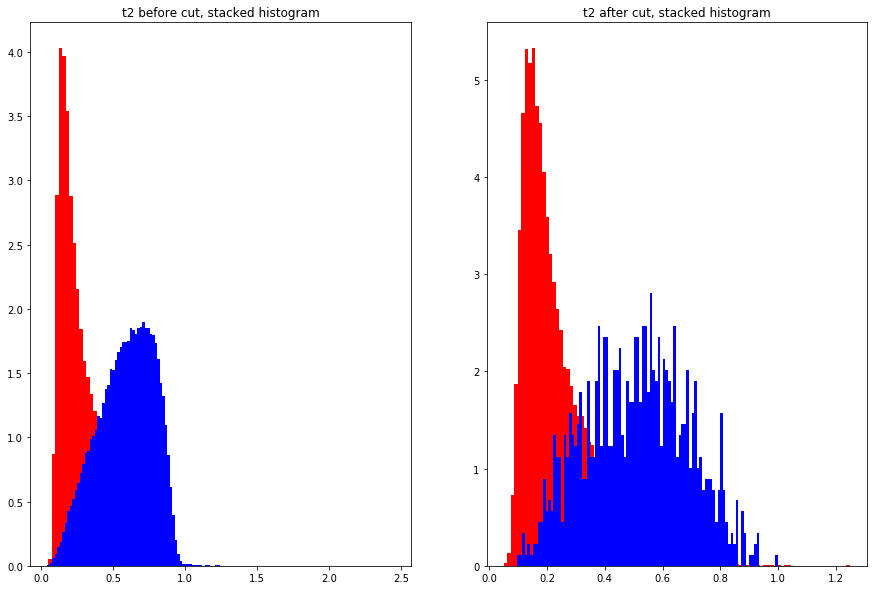

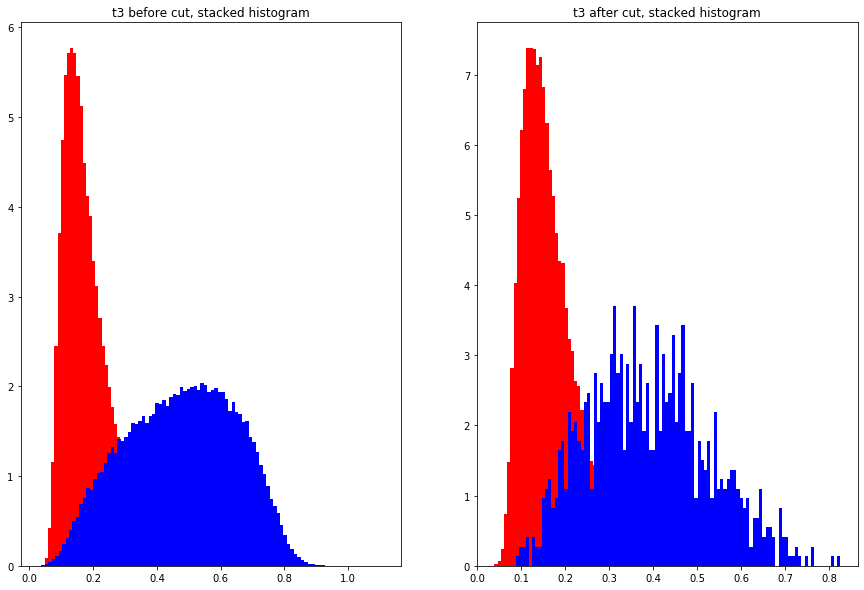

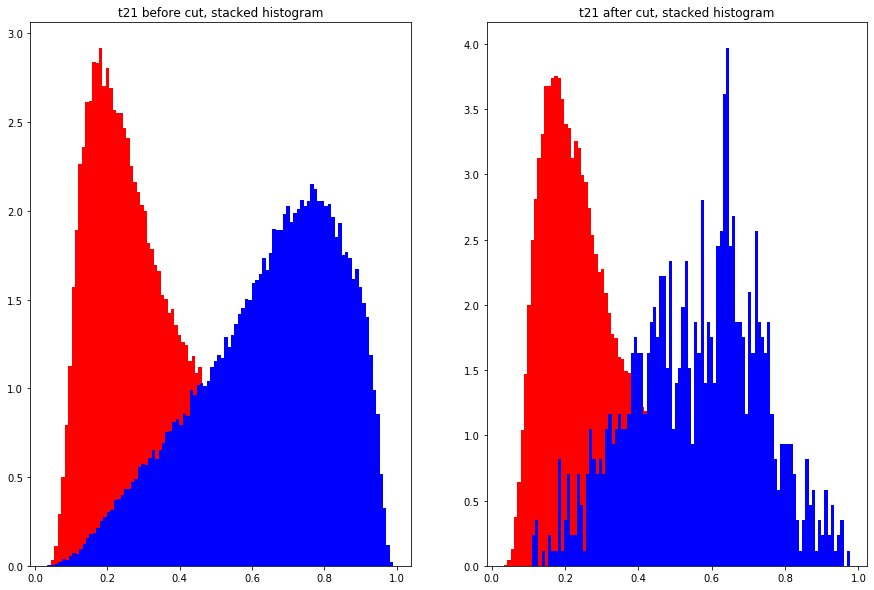

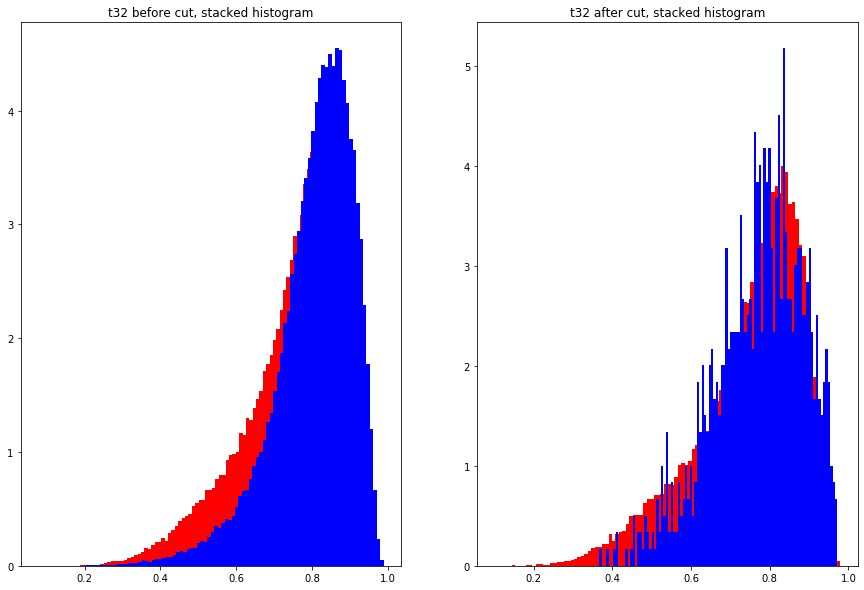

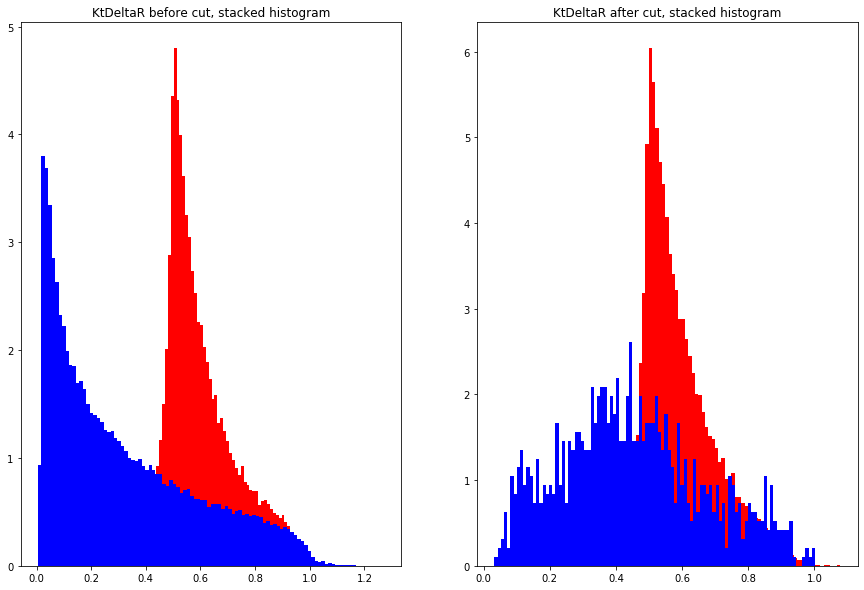

In [80]:
for key in higgs_data.keys():
    higgs_vals = []
    qcd_vals = []
    for i in range(0, len(cut_higgs_indices)):
        higgs_vals.append(higgs_data[key][cut_higgs_indices[i]])
    for j in range(0, len(cut_qcd_indices)):
        qcd_vals.append(qcd_data[key][cut_qcd_indices[j]])
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hist(higgs_data[key], 100, density=True, color='r', label='Higgs data')
    ax1.hist(qcd_data[key], 100, density=True, color='b', label='QCD data')
    ax2.hist(higgs_vals, 100, density=True, color='r', label='Higgs data')
    ax2.hist(qcd_vals, 100, density=True, color='b', label='QCD data')
    ax1.set_title(str(key) + ' before cut, stacked histogram')
    ax2.set_title(str(key) + ' after cut, stacked histogram')
    plt.show()